# Extracting Rainfall Events from ALERT rain gauges 

This notebook was developed to help users __access__, __define__, and __identify__ rainfall events from tipping-bucket rain gauge raw collected Urban Drainage and Flood Control District (UDFCD; https://udfcd.org/). Established in 1969, one of the main functions of the UDFCD is to develop and maintain an integrated flood control and warning system (aka The ALERT System) for the Denver metropolitan area in partnership with local municipalities. The ALERT rainfall gauge network includes sites with tipping bucket gauges installed as early as 1978 and with half of the network installed by 1992. Tipping bucket rain gauges are mechanical devices that directly record rainfall in increments of the bucket capacity, which for this network of gauges is 0.04 inches (1.016 mm). ALERT gauges are not heated and thus only reliably record liquid precipitation. Electronically recorded data broadcasts via radio transmission to the UDFCD. 

Because this system was designed primarily as an operational system for flash flood warnings, the UDFCD ‘…does not warrant the accuracy of the ALERT data provided…’ (https://alert5.udfcd.org/disclaimer/). Radio interference, electronic malfunctions, and mechanical anomalies due to wind, hail, snow, etc. can lead both to false high and false low measurements in the raw data. Extreme events are among the most vulnerable to such instrument errors and thus some pre-processing of the raw instrument data is necessary before rainfall event identification and analysis. 

_Developed by Matthew W. Rossi on 10.31.2018 for the Earth Lab Codefest on 11.01.2018_  

### Required Data File
4100_data.txt

This is data for ALERT station 4100 (Filter Plant Station) and is in the Betasso Creek watershed that monitored by the Boulder Creek Critical Zone Observatory. It is an active gauge that was installed in 1978 (_location_: 40.011111 N 105.334167 W _elevation_: 1944 m)

In [745]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime as dat
from scipy import interpolate as itp

In [746]:
# user inputs to convert raw data into time-series
fname = '4100_data.txt'
st = '2003-01-01 00:00:00'      # datetime begin
en = '2018-01-01 00:00:00'      # datetime 
dt = 60*1                       # averaging interval [mins]
QAQC = 0.16*25.4                # threshold flag for single tip [mm]

# derived values
dt = dt/(24*60)                                                                      # convert dt [days]
rng = dat.strptime(en, '%Y-%m-%d %H:%M:%S') - dat.strptime(st, '%Y-%m-%d %H:%M:%S')  # range of dates selected

In [747]:
# load data from text file
colspecs=[[0,10], [11,19], [20,27], [28,36], [37,45], [46,52]]
data = pd.read_fwf(fname,skiprows=16,header=1,skipfooter=4,colspecs=colspecs,parse_dates={'datetime':['Date', 'Time']},index_col=['datetime'])
data.columns = ['cum_rain_in','rain_in','raw_tips','alarm' ]
data.head()

,cum_rain_in,rain_in,raw_tips,alarm
datetime,,,,
2018-04-13 06:00:46,9.53,0.00,242,NaN
2018-04-12 18:00:46,9.53,0.08,242,NaN
2018-04-12 12:10:58,9.45,0.04,240,NaN
2018-04-12 06:00:46,9.41,0.00,239,NaN
2018-04-11 18:00:46,9.41,0.00,239,NaN


In [748]:
# subset and sort data according to user inputs
subset = data[['rain_in']].copy()*25.4
subset.columns = ['rain_mm']
subset = subset.sort_index()
subset = subset.loc[st:en]
subset.head()

,rain_mm
datetime,
2003-01-01 08:26:08,0.0
2003-01-01 20:25:50,0.0
2003-01-02 08:25:32,0.0
2003-01-02 20:25:14,0.0
2003-01-03 08:24:56,0.0


In [749]:
# use QAQC criterion to remove anomalous values
subset['flag'] = np.where(subset['rain_mm']>QAQC, 1, 0)
subset.loc[subset['rain_mm'] > QAQC, 'rain_mm'] = 0

In [750]:
# calculate cumulative rainfall
subset['cum_sum_mm'] = subset['rain_mm'].cumsum()
subset.head()

,rain_mm,flag,cum_sum_mm
datetime,,,
2003-01-01 08:26:08,0.0,0,0.0
2003-01-01 20:25:50,0.0,0,0.0
2003-01-02 08:25:32,0.0,0,0.0
2003-01-02 20:25:14,0.0,0,0.0
2003-01-03 08:24:56,0.0,0,0.0


In [751]:
# construct numpy arrays of relative time and cumulative rainfall
t = subset.index                                 # pull out datetime
t = t - dat.strptime(st, '%Y-%m-%d %H:%M:%S')    # difference datetime with start
t = t.days + (t.seconds/(60*60*24))              # convert to decimal days
t = np.insert(t,0,0)                             # pad first value with 0
t = np.insert(t,len(t),max(t)+1)                 # past last value with 1 day

cum = subset['cum_sum_mm'].values                # pull out cumulative rainfall
cum = np.insert(cum,0,0)                         # pad first value with 0
cum = np. insert(cum,len(cum), max(cum))         # pad last value with max cum

In [752]:
# initialize and fill interpolated arrays (i.e., constant time step)
ti = np.arange(0, rng.days, dt)                  # relative time for interp [days]
ti2 = ti - dt                                    # shifted x-axis for rainfall rates [days]
cumi = itp.interp1d(t,cum)(ti)                   # cumulative rainfall at ti [mm]

rate = [0]*len(ti)
for i in range(1,len(ti)):
    rate[i] = cumi[i]-cumi[i-1]

In [753]:
print('The maximum rainfall rate is',round(max(rate)),'mm/hr at an averaging interval of',round(dt*24*60),'minutes!')

The maximum rainfall rate is 46.0 mm/hr at an averaging interval of 60 minutes!


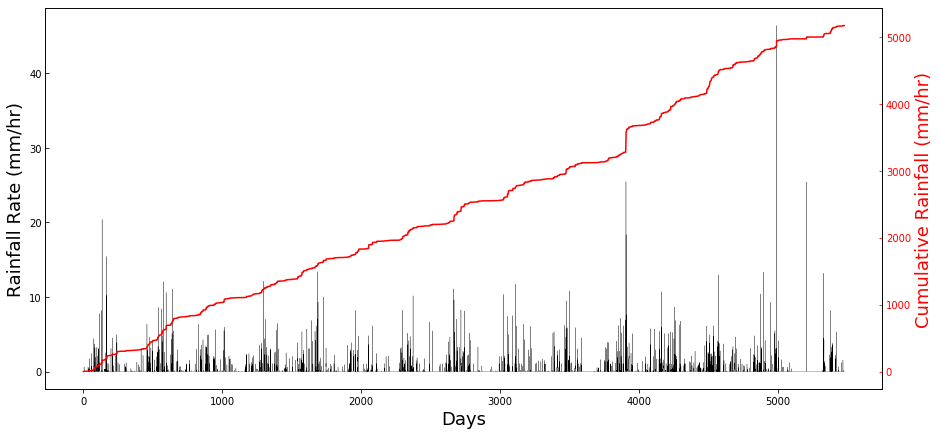

In [754]:
# visualize the time series
fig, ax = plt.subplots(figsize=(15,7))

# plot up rainfall rates in black
plt.plot(ti2,rate, color='k', linewidth=0.25)
ax.set_ylabel('Rainfall Rate (mm/hr)', color='k', fontsize=18)
ax.tick_params('y', colors='k', direction='in')
ax.set_xlabel('Days', color='k', fontsize=18)

# plot up cumulative rainfall in red
ax2 = ax.twinx()
ax2.plot(ti,cumi, color='r')
ax2.set_ylabel('Cumulative Rainfall (mm/hr)', color='r', fontsize=18)
ax2.tick_params('y', colors='r', direction='in')

## How are rainfall rates sensitive to user decisions ?

1. When is the most intense event on record? Is this the case regardless of user decisions?
2. What is the effect of the time averaging window you chose (e.g., 60 minutes vs. 24 hours)?
3. What are derived rainfall rates most senstive to?
4. How would our event statistics change if we altered our criteria for identifying anomalous readings?

In [755]:
## specify criteria to identify events
thres = 4     # mm/hr
lag = 2       # dtt

In [756]:
# first identify which time steps meet event criteria
xi = np.where(np.asarray(rate)>thres,1,0)           # identify all time above thrshold
xim = np.empty(len(rate))                           # initialize array for event criteria

# for loop accumulates time steps that meet event criteria 
for i in range(0,len(xi)-lag):
    xim[i] = sum(xi[i:i+lag+1])       

# identify all time steps within events
events = np.where(xim>0,1,0)

In [757]:
# give each event a unique id
eid = np.empty(len(rate))
id = 0

for i in range(lag,len(xi)-lag-1):
    check = (2*events[i]-events[i-1])
    
    if check==1:
        eid[i] = 0
    elif check>=2:
        id=id+1
        eid[i] = id
    else:
        eid[i] = 0

rate_ev = events * rate
no_events = max(eid)
               
print('There are',no_events,'events that meet these criteria!')

There are 141.0 events that meet these criteria!


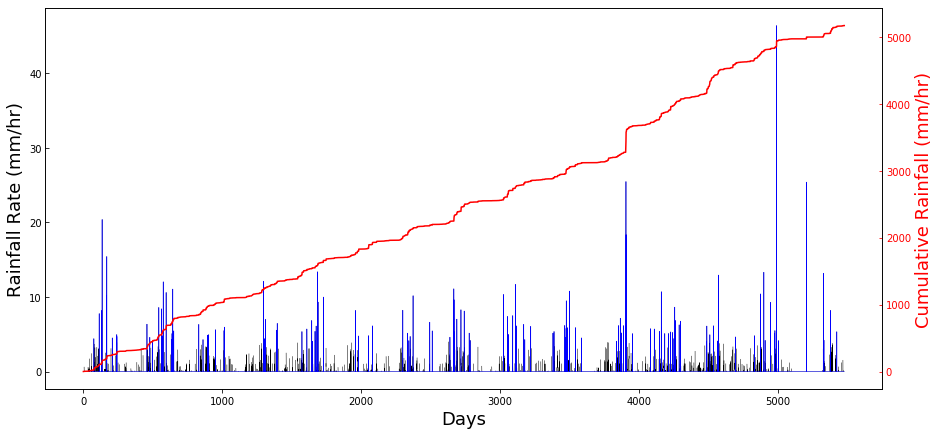

In [758]:
# visualize the time series
fig, ax = plt.subplots(figsize=(15,7))

# plot up rainfall rates in black with events highlighted in blue
plt.plot(ti2,rate, color='k', linewidth=0.25)
plt.plot(ti2,rate_ev, color='b', linewidth=0.5)

ax.set_ylabel('Rainfall Rate (mm/hr)', color='k', fontsize=18)
ax.tick_params('y', colors='k', direction='in')
ax.set_xlabel('Days', color='k', fontsize=18)

# plot up cumulative rainfall in red
ax2 = ax.twinx()
ax2.plot(ti,cumi, color='r')
ax2.set_ylabel('Cumulative Rainfall (mm/hr)', color='r', fontsize=18)
ax2.tick_params('y', colors='r', direction='in')

## What statistical properties might we want extract from events?
This likely depends on what processes we are interested in (e.g., floods, overland flow erosion, landslides).